<a href="https://colab.research.google.com/github/vkthakur90/jupyter_notebooks/blob/master/Laplacian_of_Gaussian_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import google.colab.files as gcf

In [2]:
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import tensorflow.keras.models as tfkm
import tensorflow.keras.utils as tfku

In [3]:
print("Tensorflow version " + tf.__version__)

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime;')

Tensorflow version 2.12.0
Running on TPU  ['10.82.30.58:8470']


In [4]:
!ls

uploaded = gcf.upload()

for k, v in uploaded.items():
    with open(k, 'wb') as f:
        f.write(v)

!ls

model.png  sample_data	sid_kiara.webp


model.png  sample_data	sid_kiara.webp


In [5]:
img = tfku.load_img('sid_kiara.webp', target_size = [480, 640], keep_aspect_ratio = True)
img_arr = tfku.img_to_array(img)

In [6]:
@tfku.register_keras_serializable()
class GaussianConv(tfkl.Layer):
    def __init__(self):
        super().__init__()

    def get_config(self):
        return super().get_config()

    def build(self, input_shape):
        inp = tfkl.Input(input_shape[1:])
        gaussian = tfkl.DepthwiseConv2D((3, 3), use_bias = False, padding = 'same')

        gaussian_filter = np.array([
            [1/16, 2/16, 1/16],
            [2/16, 4/16, 2/16],
            [1/16, 2/16, 1/16]
        ])[..., np.newaxis, np.newaxis]


        x = inp
        x = tfkl.Lambda(lambda t: tf.split(t, num_or_size_splits = input_shape[-1], axis = -1))(x)
        x = [gaussian(t) for t in x]
        x = tfkl.Concatenate(axis = -1)(x)

        out = x

        gaussian.set_weights([gaussian_filter])

        gaussian.trainable = False

        self.forward = tfkm.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.forward(input)

In [7]:
@tfku.register_keras_serializable()
class LaplacianConv(tfkl.Layer):
    def __init__(self):
        super().__init__()

    def get_config(self):
        return super().get_config()

    def build(self, input_shape):
        inp = tfkl.Input(input_shape[1:])
        laplacian = tfkl.DepthwiseConv2D((3, 3), use_bias = False, padding = 'same')

        laplacian_filter = np.array([
            [ 0.0, -1.0,  0.0],
            [-1.0,  4.0, -1.0],
            [ 0.0, -1.0,  0.0]
        ])[..., np.newaxis, np.newaxis]

        x = inp
        x = tfkl.Lambda(lambda t: tf.split(t, num_or_size_splits = input_shape[-1], axis = -1))(x)
        x = [laplacian(t) for t in x]
        x = tfkl.Concatenate(axis = -1)(x)

        out = x

        laplacian.set_weights([laplacian_filter])

        laplacian.trainable = False


        self.forward = tfkm.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.forward(input)

In [8]:
@tfku.register_keras_serializable()
class DownPoolLayer(tfkl.Layer):
    def __init__(self):
        super().__init__()

    def get_config(self):
        return super().get_config()

    def build(self, input_shape):
        inp = tfkl.Input(input_shape[1:])

        x = inp

        z1 = tfkl.MaxPool2D((2, 2))(x)
        z2 = tfkl.Lambda(lambda t: -t)(x)
        z2 = tfkl.MaxPool2D((2, 2))(z2)
        z2 = tfkl.Lambda(lambda t: -t)(z2)
        y = tfkl.Concatenate(axis = -1)([z1, z2])

        out = y

        self.forward = tfkm.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.forward(input)

In [9]:
@tfku.register_keras_serializable()
class EdgeDetectionLayer(tfkl.Layer):
    def __init__(self):
        super().__init__()

    def get_config(self):
        return super().get_config()

    def build(self, input_shape):
        inp = tfkl.Input(input_shape[1:])

        x = inp

        x = GaussianConv()(x)
        x = LaplacianConv()(x)
        x = tfkl.ReLU()(x)

        out = x

        self.forward = tfkm.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.forward(input)

In [10]:
@tfku.register_keras_serializable()
class PyramidConvFeatures(tfkl.Layer):
    def __init__(self):
        super().__init__()

    def get_config(self):
        return super().get_config()

    def build(self, input_shape):
        inp = tfkl.Input(input_shape[1:])

        x = inp
        x = tfkl.Rescaling(scale = 1/127.5, offset = -1)(x)

        x0 = EdgeDetectionLayer()(x)
        x = DownPoolLayer()(x)

        x1 = EdgeDetectionLayer()(x)
        x = DownPoolLayer()(x)

        x2 = EdgeDetectionLayer()(x)
        x = DownPoolLayer()(x)

        x3 = EdgeDetectionLayer()(x)
        x = DownPoolLayer()(x)

        x4 = EdgeDetectionLayer()(x)
        x = DownPoolLayer()(x)

        x5 = EdgeDetectionLayer()(x)

        x = tfkl.UpSampling2D((2, 2), interpolation = 'nearest')(x5)

        x = tfkl.Concatenate(axis = -1)([x4, x])
        x = tfkl.UpSampling2D((2, 2), interpolation = 'nearest')(x)


        x = tfkl.Concatenate(axis = -1)([x3, x])
        x = tfkl.UpSampling2D((2, 2), interpolation = 'nearest')(x)

        x = tfkl.Concatenate(axis = -1)([x2, x])
        x = tfkl.UpSampling2D((2, 2), interpolation = 'nearest')(x)

        x = tfkl.Concatenate(axis = -1)([x1, x])
        x = tfkl.UpSampling2D((2, 2), interpolation = 'nearest')(x)

        x = tfkl.Concatenate(axis = -1)([x0, x])

        out = x

        self.forward = tfkm.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.forward(input)

In [11]:
def create_base_model():
    img = tfkl.Input([480, 640, 3], name = 'image')
    labels = tfkl.Input([10], name = 'labels')

    x = PyramidConvFeatures()(img)
    x = tfkl.BatchNormalization(axis = -1)(x)
    x = tfkl.Reshape([480 * 640, -1])(x)
    x = tfkl.BatchNormalization(axis = -1)(x)

    features = x

    class_embed = tfkl.Embedding(input_dim = 10, output_dim = 189)(labels)


    x = features
    y = class_embed

    for _ in range(3):
        res = x
        x1 = tfkl.BatchNormalization(axis = -1)(x)
        y1 = tfkl.BatchNormalization(axis = -1)(y)
        x = tfkl.Attention(use_scale = True)([x1, y1])
        x = tfkl.Add()([x, res])

        res = y
        x1 = tfkl.BatchNormalization(axis = -1)(x)
        y1 = tfkl.BatchNormalization(axis = -1)(y)
        y = tfkl.Attention(use_scale = True)([y1, x1])
        y = tfkl.Add()([y, res])

    x = tfkl.Dense(3)(x)
    x = tfkl.Activation('tanh')(x)
    x = tfkl.Reshape([480, 640, -1])(x)

    out = x

    model = tfkm.Model(inputs = [img, labels], outputs = [out])

    model.compile(
        optimizer = 'adam',
        loss = 'mean_squared_error'
    )

    return model

In [12]:
with tpu_strategy.scope():
    model = create_base_model()

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 480, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 pyramid_conv_features (Pyramid  (None, 480, 640, 18  108        ['image[0][0]']                  
 ConvFeatures)                  9)                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 480, 640, 18  756        ['pyramid_conv_features[0][0]']  
 alization)                     9)                                                            

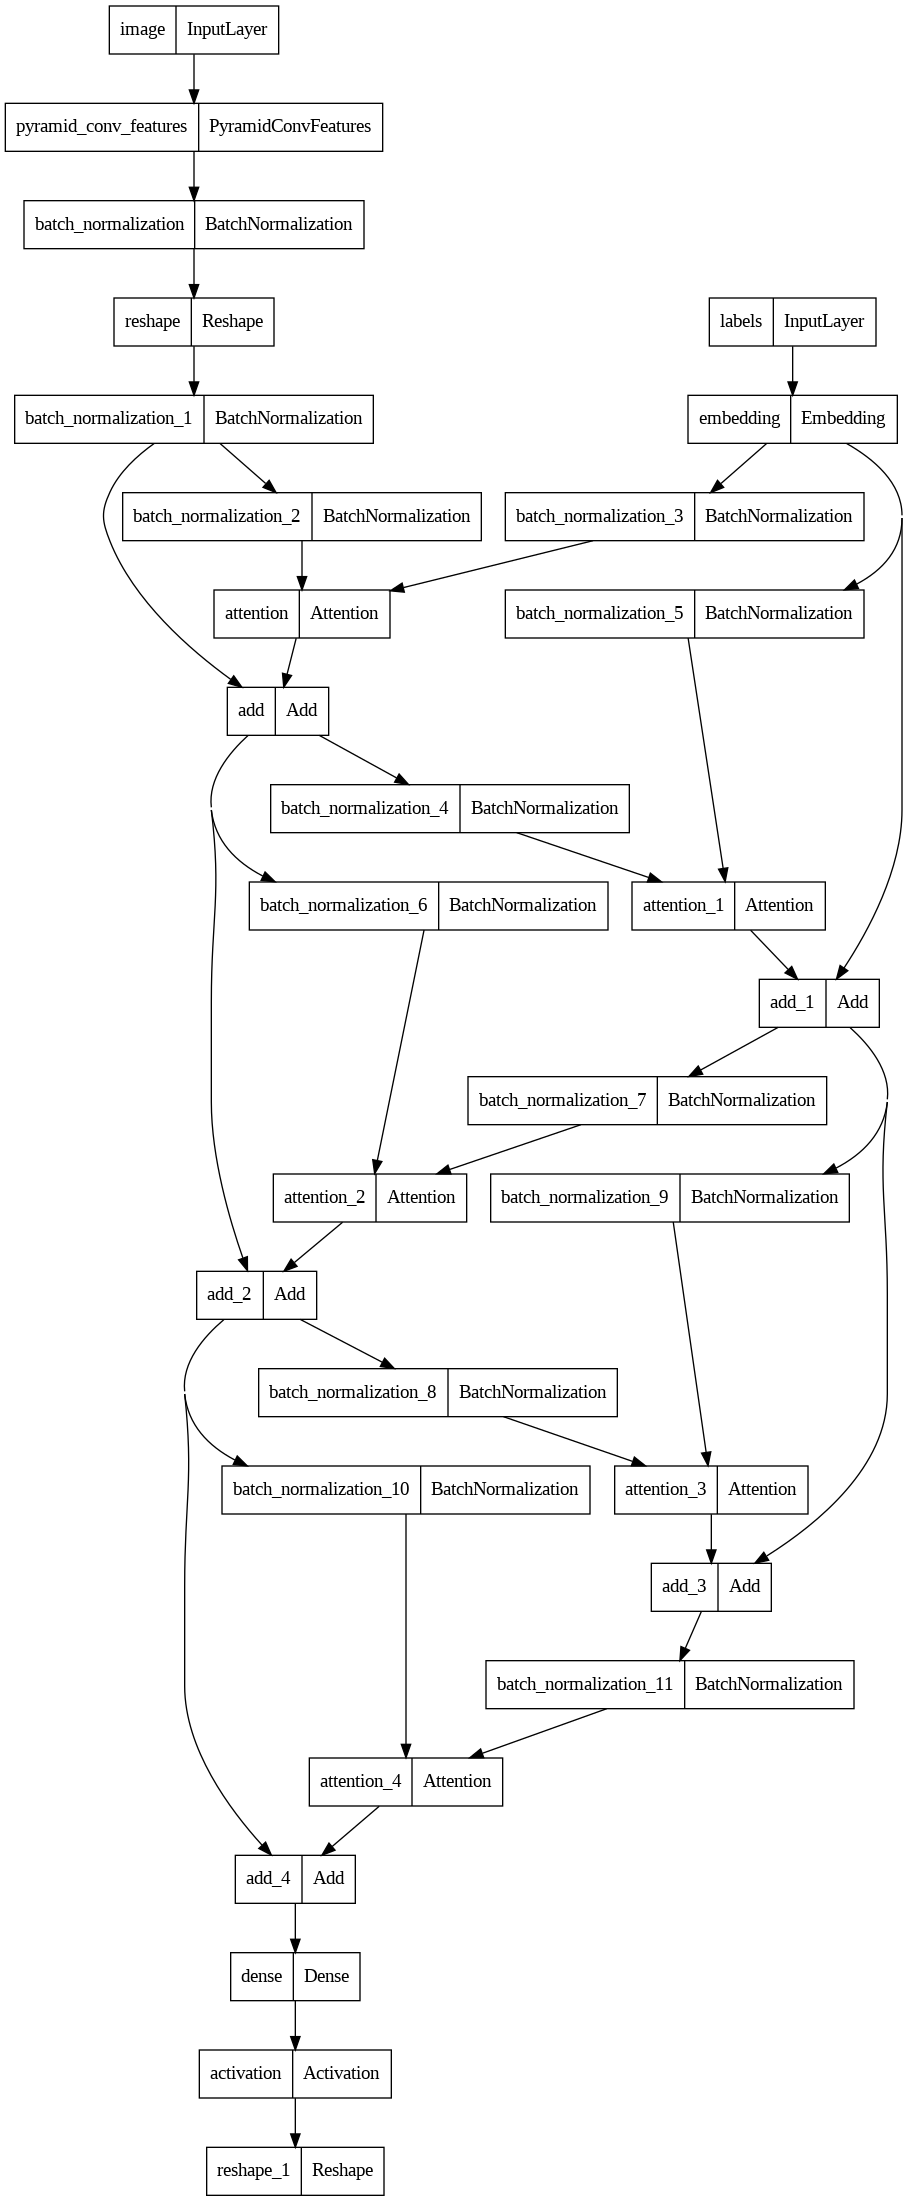

In [14]:
tfku.plot_model(model)

In [15]:
train_img = img_arr[np.newaxis, ...]
pred_img = train_img/127.5 - 1
labels = np.stack(train_img.shape[0] * [np.arange(10)], axis = 0)

In [16]:
labels.shape

(1, 10)

In [25]:
dataset = (
    tf.data.Dataset.from_tensor_slices(((train_img, labels), pred_img))
                   .repeat(10000)
                   .batch(8)
)

model.fit(dataset)

1250/1250 [==============================] - 665s 532ms/step - loss: 0.0423


In [30]:
pred_x = model.predict([train_img, labels])

norm_pred_x = np.uint8(127.5 * (pred_x + 1))

1/1 [==============================] - 2s 2s/step


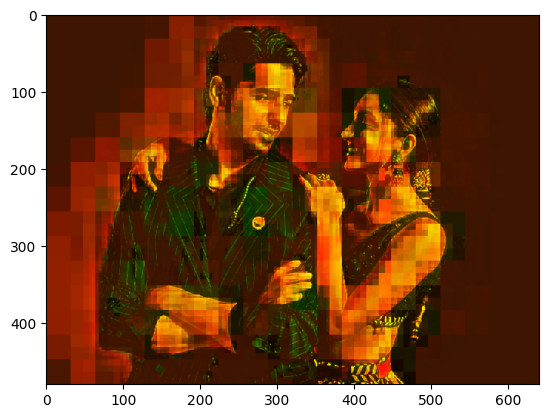

In [31]:
plt.imshow(norm_pred_x[0])

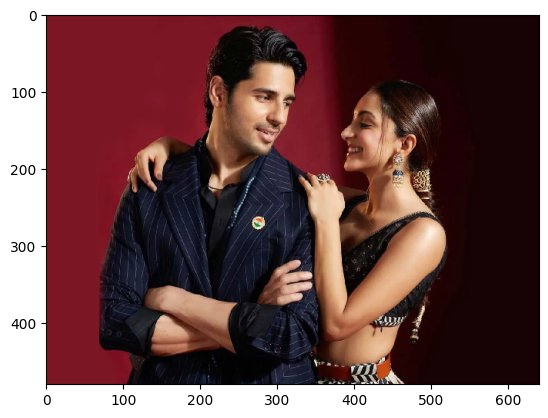

In [28]:
plt.imshow(np.uint8(img_arr))

In [21]:
#tf.saved_model.save(model, 'log_autoencoder')

In [22]:
#!ls log_autoencoder

In [23]:
#!zip -r log_autoencoder.zip log_autoencoder

In [24]:
#gcf.download('log_autoencoder.zip')